# Numerical resolving of the problem of PBD analogy with horizon
Let us introduce:
* $p(t)$: probability of a *good* lineage to have itself and any descendant go extinct before horizon $t$, before any speciation event 
* $p_n(t)$ probability of a good lineage to have exactly $n$ direct incipient daughter lineages, that would all go extinct before $t$ and itself going extinct before $t$ before any speciation event, 
* $p^I(t)$: probability of an *incipient* lineage to have itself and any descendant go extinct before horizon $t$,
* $p^I_n(t)$: probability of an incipient lineage to have exactly $n$ direct incipient daughter lineages, that would all go extinct before $t$ and itself going extinct before $t$ before any speciation event

We have then:
$$p^I_0(t) = \frac{\mu_2}{\lambda_2 + \lambda_3 + \mu_2}(1 - e^{-(\lambda_2 + \lambda_3 + \mu_2) t})
 = \frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t})$$
 with $\Lambda := \lambda_2 + \lambda_3 + \mu_2$.

An incipient lineage has exactly $n\ge 1$ daughter that would die before $t$ and dies before $t$ if and only if 
* it has 1 daughter at time $s<t$ (density $\lambda_3 e^{-\Lambda s}$)
* this daughter goes extinct in the remaining time $t-s$ (probability $p^I(t-s)$)
* the main lineage has $n-1$ daughter that would die before $t-s$ in the remaining time (probability $ p_{n-1}^I (t-s)$). 

Therefore:
$$p_n^I(t) = \int_0^t \lambda_3 e^{-\Lambda s} p^I(t-s) p_{n-1}^I (t-s) d s.$$

Since $p^I(t) = \sum_{n=0}^{+\infty} p_n^I(t)$ we have:

\begin{align}
    p^I(t) &= p_0^I(t) + \sum_{n = 1}^{+\infty} p_n^I(t) \\ 
    &= \frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t}) + \sum_{n = 1}^{+\infty}\int_0^t \lambda_3 e^{-\Lambda s} p^I(t-s) p_{n-1}^I (t-s) d s \\ 
    &= \frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t}) + \lambda_3 \int_0^t e^{-\Lambda s} p^I(t-s) \left(\sum_{n = 1}^{+\infty} p_{n-1}^I (t-s)\right) ds \\
    &= \frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t}) + \lambda_3 \int_0^t e^{-\Lambda s} p^I(t-s)^2 d u \\
    &= \frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t}) + \lambda_3  e^{-\Lambda t}\int_0^t e^{\Lambda u} p^I(u)^2 d u
\end{align}

Applying the same reasonning to good lineages, we have a similar induction formula for $p_n(t)$, with $n \ge 1$:

$$p_n(t) = \lambda_1 e^{-\Theta t} \int_0^t  e^{\Theta u} p^i(u) p_{n-1} (u) du$$
where $\Theta = \lambda_1 + \mu_1$.

Since $p(t) = \sum_{n = 0}^{+\infty} p_n(t)$ and 
$$p_0(t) = \frac{\mu_1}{\Theta} ( 1 - e^{-\Theta t})$$
we have:
\begin{align}
    p(t) &= \frac{\mu_1}{\Theta} ( 1 - e^{-\Theta t}) + \lambda_1 e^{-\Theta t}  \int_0^t e^{\Theta u} p^I(u) \left(\sum_{n = 1} ^{\infty} p_{n-1}  (u) \right) d u\\ 
    &= \frac{\mu_1}{\Theta} ( 1 - e^{-\Theta t}) + \lambda_1 e^{-\Theta t}  \int_0^t e^{\Theta u} p^I(u) p(u) d u
\end{align}

Let us integrate this expression numerically

In [59]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("customstyle")
import sys
sys.path.append("../modules")
import PBD_analog
from scipy.optimize import curve_fit

colors = ["#" + x for x in ["000000","cf5c36","bcd696","985f99","9684a1"]]

In [60]:
# Numerically solving p(t) and pI(t)
l1, l2, l3, m1, m2 = 0.5, 0.24, 0.4, 0.2,0.2

par = dict(l1 = l1, l2 = l2, l3 = l3, m1 = m1, m2 = m2)
Lambda = l2 + l3 + m2
Theta = l1 + m1
T = np.linspace(0, 20, int(1e6))
pI = np.zeros_like(T)
p = np.zeros_like(T)
integrandI = np.full_like(T, np.nan)
integrand = np.full_like(T, np.nan)
integrandI[0] = 0.0
integrand[0] = 0 # pI(0) = 0, p(0) = 0


for i in range(1, len(T)):
    # Euler method
    elt = np.exp(-Lambda * T[i])
    pI[i] = m2 / Lambda * (1 - elt) + l3 * elt * np.sum(integrandI[:i])
    integrandI[i] = (T[i] - T[i-1]) * np.exp(Lambda * T[i]) * pI[i]**2

    ett = np.exp(-Theta * T[i])
    p[i] = m1 / Theta * (1 - ett) + l1 * ett * np.sum(integrand[:i])
    integrand[i] = (T[i] - T[i-1]) * np.exp(Theta * T[i]) * pI[i] * p[i]

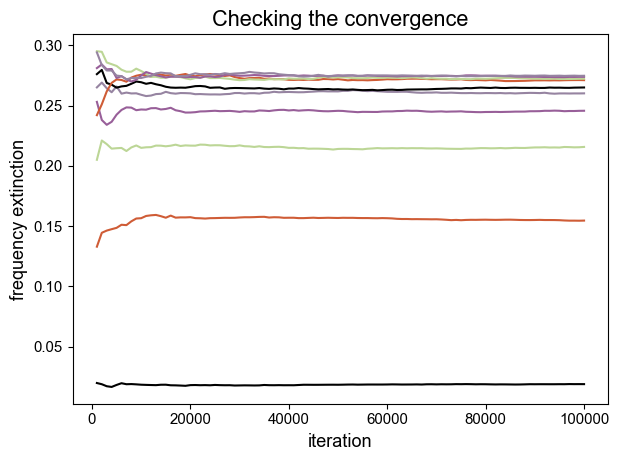

In [61]:
# Simulations (takes some time)
# -- Start with incipient lineage 
sim_param = {'n_sim':int(1e5), 'step':int(1e3), 'n_g0':0, 'n_i0':1}
horizons = np.linspace(0.1, 10, 10)
fig, ax = plt.subplots()

pI_sim = np.zeros_like(horizons)

iter = np.linspace(sim_param['step'], sim_param['n_sim'], sim_param['n_sim'] // sim_param['step'])

for i in range(len(horizons)):
    sim = PBD_analog.simul_prot_etienne(**par, **sim_param, horizon=horizons[i])
    ax.plot(iter, sim["F_extinction"], label = str(i))
    pI_sim[i] = np.sum(sim["Extinction"]) / len(sim["Extinction"])

ax.set_xlabel("iteration")
ax.set_ylabel("frequency extinction")
ax.set_title("Checking the convergence");

c:\Users\pveron\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pveron\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


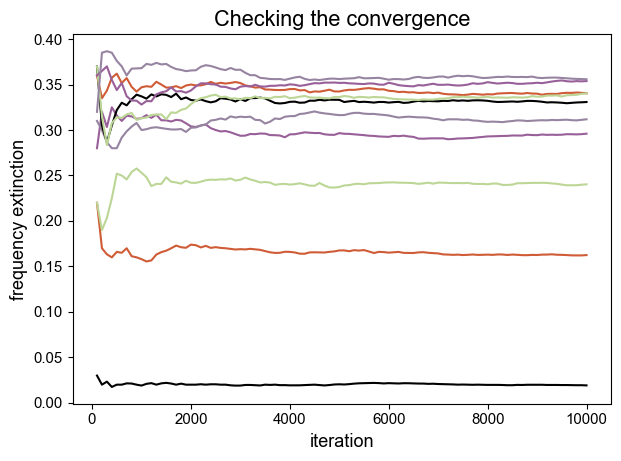

In [62]:
# Simulations (takes some time)
# -- Start with good lineage 
sim_param = {'n_sim':int(1e4), 'step':int(1e2), 'n_g0':1, 'n_i0':0}

fig, ax = plt.subplots()
p_sim = np.zeros_like(horizons)

iter = np.linspace(sim_param['step'], sim_param['n_sim'], sim_param['n_sim'] // sim_param['step'])

for i in range(len(horizons)):
    sim = PBD_analog.simul_prot_etienne(**par, **sim_param, horizon=horizons[i])
    ax.plot(iter, sim["F_extinction"], label = str(i))
    p_sim[i] = np.sum(sim["Extinction"]) / len(sim["Extinction"])

ax.set_xlabel("iteration")
ax.set_ylabel("frequency extinction")
ax.set_title("Checking the convergence");

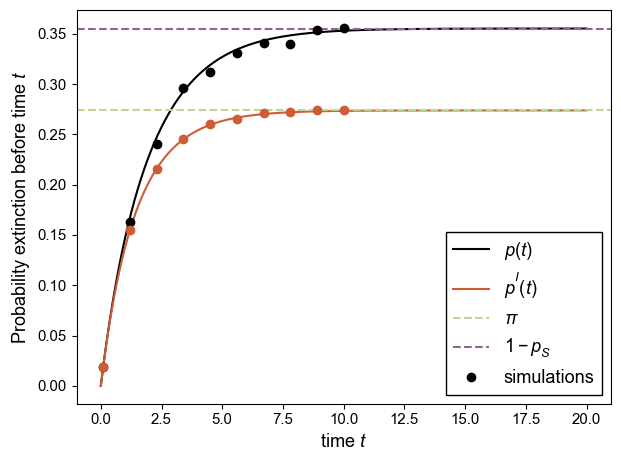

In [63]:
# Comparing predictions and simulations

fig, ax = plt.subplots()

ax.plot(T, p, label = "$p(t)$")
ax.plot(T, pI, label = "$p^I(t)$")

ax.axhline(PBD_analog.pi(**par), ls = "--", color = colors[2], label = "$\pi$")
ax.axhline(1-PBD_analog.p_speciation(**par), ls = "--", color = colors[3], label = "$1 - p_S$")
ax.plot(horizons, p_sim, ls = "", marker = "o", color = "k", label = "simulations")
ax.plot(horizons, pI_sim, ls = "", marker = "o", color = colors[1])
ax.set_xlabel("time $t$")
ax.set_ylabel("Probability extinction before time $t$")
ax.legend()

In [64]:
F = np.zeros_like(pI)
expLT = np.exp(Lambda * T)
for i in range(1, len(T)):
    F[i] = np.trapz(y = expLT[:i+1] * np.power(pI[:i+1], 2), x = T[:i+1])

fig, ax = plt.subplots()

ax.plot(T, F)
ax.set_ylabel("$F(t) := \\int_0^t e^{\\Lambda u} p_I^2(u) du$")
ax.set_xlabel("time $t$")


def Ffit(t, alpha, C):
    return C * np.power(t, 3) * np.exp(alpha * t)

fit = curve_fit(Ffit, T, F, p0 = (1.0,1.0))
print(fit)

ax.plot(T, Ffit(T, *fit[0]), ls = "--")
ax.set_yscale("log")
ax.set_xscale("log")

KeyboardInterrupt: 

0.5177584878137248
0.7


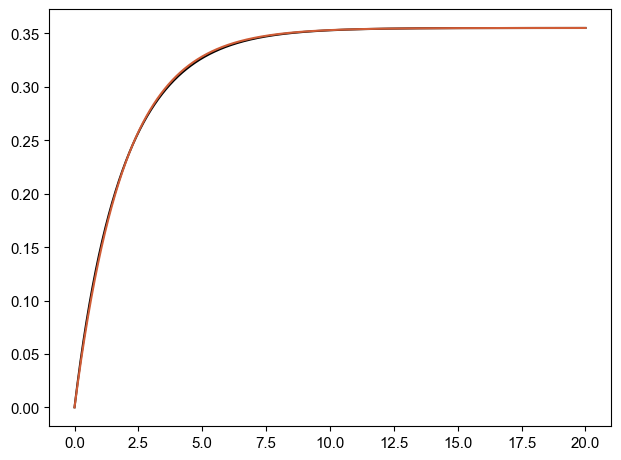

In [65]:
# Fitting to exponential

p_spec = PBD_analog.p_speciation(**par)

def f(t, alpha):
    return (1 - p_spec) * (1 - np.exp(-alpha * t))

opt = curve_fit(f, T, p, p0 = 1.0)
opt

fig, ax = plt.subplots()
ax.plot(T, p)
ax.plot(T, f(T, opt[0]))

print(opt[0][0])
print(Theta)

0.6807999629988156
0.8400000000000001


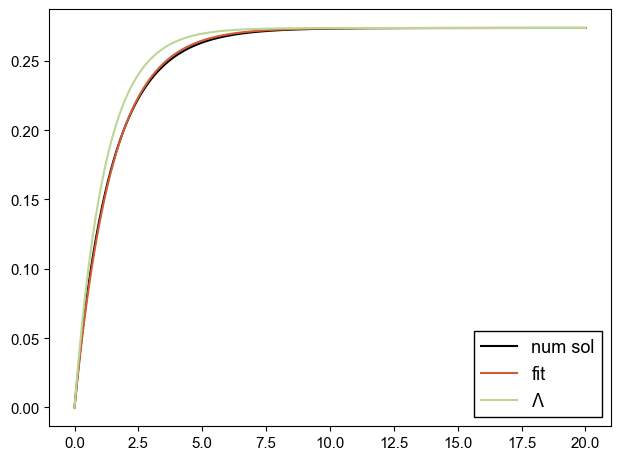

In [66]:
# Fitting to exponential

pi = PBD_analog.pi(**par)

def g(t, alpha):
    return pi * (1 - np.exp(-alpha * t))

optI = curve_fit(g, T, pI, p0 = 1.0)
optI

fig, ax = plt.subplots()
ax.plot(T, pI, label = "num sol")
ax.plot(T, g(T, optI[0]), label = "fit")
ax.plot(T, g(T, Lambda), label = "$\\Lambda$")
ax.legend()
print(optI[0][0])
print(Lambda)

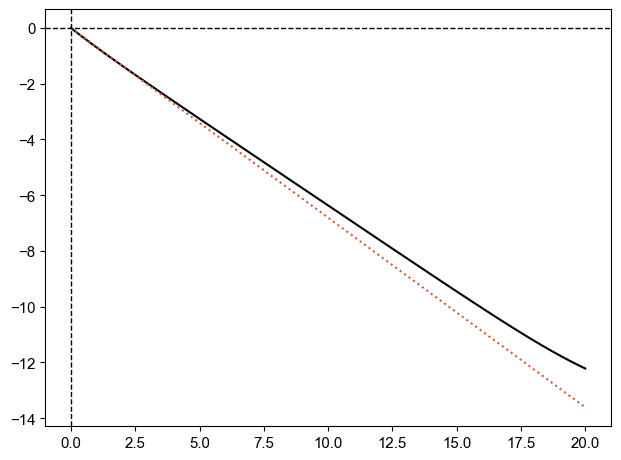

In [67]:
fig, ax = plt.subplots()
ax.plot(T, np.log(1-pI / pi), label = "num sol")
ax.plot(T, -optI[0] *T, ls = ":")
ax.axhline(0, ls = "--", color = "k", lw = 1)
ax.axvline(0, ls = "--", color = "k", lw = 1)